In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# INTRODUCTION

The House Prices: Advanced Regression Techniques competition on Kaggle challenges participants to predict the final sale price of homes in Ames, Iowa, based on 79 explanatory variables describing various aspects of each house. This is a classic regression problem where the target variable is the continuous SalePrice.

In this notebook, I will:

Explore the dataset and handle missing values.

Preprocess the data (normalization, log transformation, one-hot encoding).

Train and compare several models (ANN, Random Forest, etc.).

Select the best model to make predictions on the test set and submit to Kaggle.

The goal is to build a clear, reproducible pipeline and achieve a strong score on the leaderboard.

# Overview of the datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer plots

# Load datasets
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Basic info
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Preview data
display(train.head())

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
import random
import tensorflow as tf
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-09-14 10:02:17.200868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757844137.499753      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757844137.604474      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [5]:
train.describe(include=[object]).transpose()

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


In the table we got, count represents the number of non-null values in each column, unique represents the number of unique values, top represents the most frequent element, and freq represents the frequency of the most frequent element.

# CLEANING DATASETS

In [6]:
#getting the number of missing data
num_missing = train.isnull().sum()
#excluding non missing column
num_missing = num_missing[num_missing>0]
#percentage of missing data
percent_missing = num_missing*100/train.shape[0]
#concatenating the missing number and missing percentage into DataFrame and sorting it
pd.concat([num_missing,percent_missing], axis=1, keys=['Missing Values', 'Percentage']).sort_values(by ='Missing Values', ascending=False)

,Missing Values,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [7]:
train['PoolQC'] = train['PoolQC'].fillna("No Pool")
train['MiscFeature'] = train['MiscFeature'].fillna('No Feature')
train['Alley'] = train['Alley'].fillna('No Alley')
train['Fence'] = train['Fence'].fillna('No Fence')
train['MasVnrType'] = train['MasVnrType'].fillna('No Mas Vnr Type')
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['LotFrontage'] = train['LotFrontage'].fillna(0)
train['GarageCars']= train['GarageCars'].fillna(0)
train['GarageArea']= train['GarageArea'].fillna(0)
train['GarageYrBlt']= train['GarageYrBlt'].fillna(0)
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [8]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
  train[col] = train[col].fillna("No Garage")

for col in ['BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']:
  train[col] = train[col].fillna(0)

for col in ["BsmtExposure", "BsmtFinType2", "BsmtFinType1", "BsmtQual", "BsmtCond"]:
  train[col] = train[col].fillna("No Basement")


In [9]:
#check if there is any remaining missing value
train.isnull().values.sum()

0

# OUTLIER REMOVAL

In [10]:
#check outliers for numeric columns
numeric_cols = train.select_dtypes(include=['int64','float64']).columns
Q1 = train[numeric_cols].quantile(0.25)
Q3 = train[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
outliers = (train[numeric_cols] < lower_bound) | (train[numeric_cols] > upper_bound)

In [11]:
outliers_count = outliers.sum().sort_values(ascending=False)
print(outliers_count)

EnclosedPorch    208
BsmtFinSF2       167
OverallCond      125
ScreenPorch      116
MSSubClass       103
MasVnrArea        98
BsmtHalfBath      82
GarageYrBlt       81
OpenPorchSF       77
LotArea           69
KitchenAbvGr      68
SalePrice         61
TotalBsmtSF       61
MiscVal           52
BedroomAbvGr      35
WoodDeckSF        32
GrLivArea         31
TotRmsAbvGrd      30
BsmtUnfSF         29
LowQualFinSF      26
3SsnPorch         24
GarageArea        21
1stFlrSF          20
LotFrontage       16
PoolArea           7
BsmtFinSF1         7
YearBuilt          7
Fireplaces         5
GarageCars         5
2ndFlrSF           2
OverallQual        2
BsmtFullBath       1
MoSold             0
YrSold             0
Id                 0
HalfBath           0
YearRemodAdd       0
FullBath           0
dtype: int64


There are quite a few outliers in many columns so we focus on examining them and their impacts on the important columns of dataset (SalePrice ~ Gr Liv Area, SalePrice ~ Lot Area, SalePrice ~ Total Bsmt SF,...)

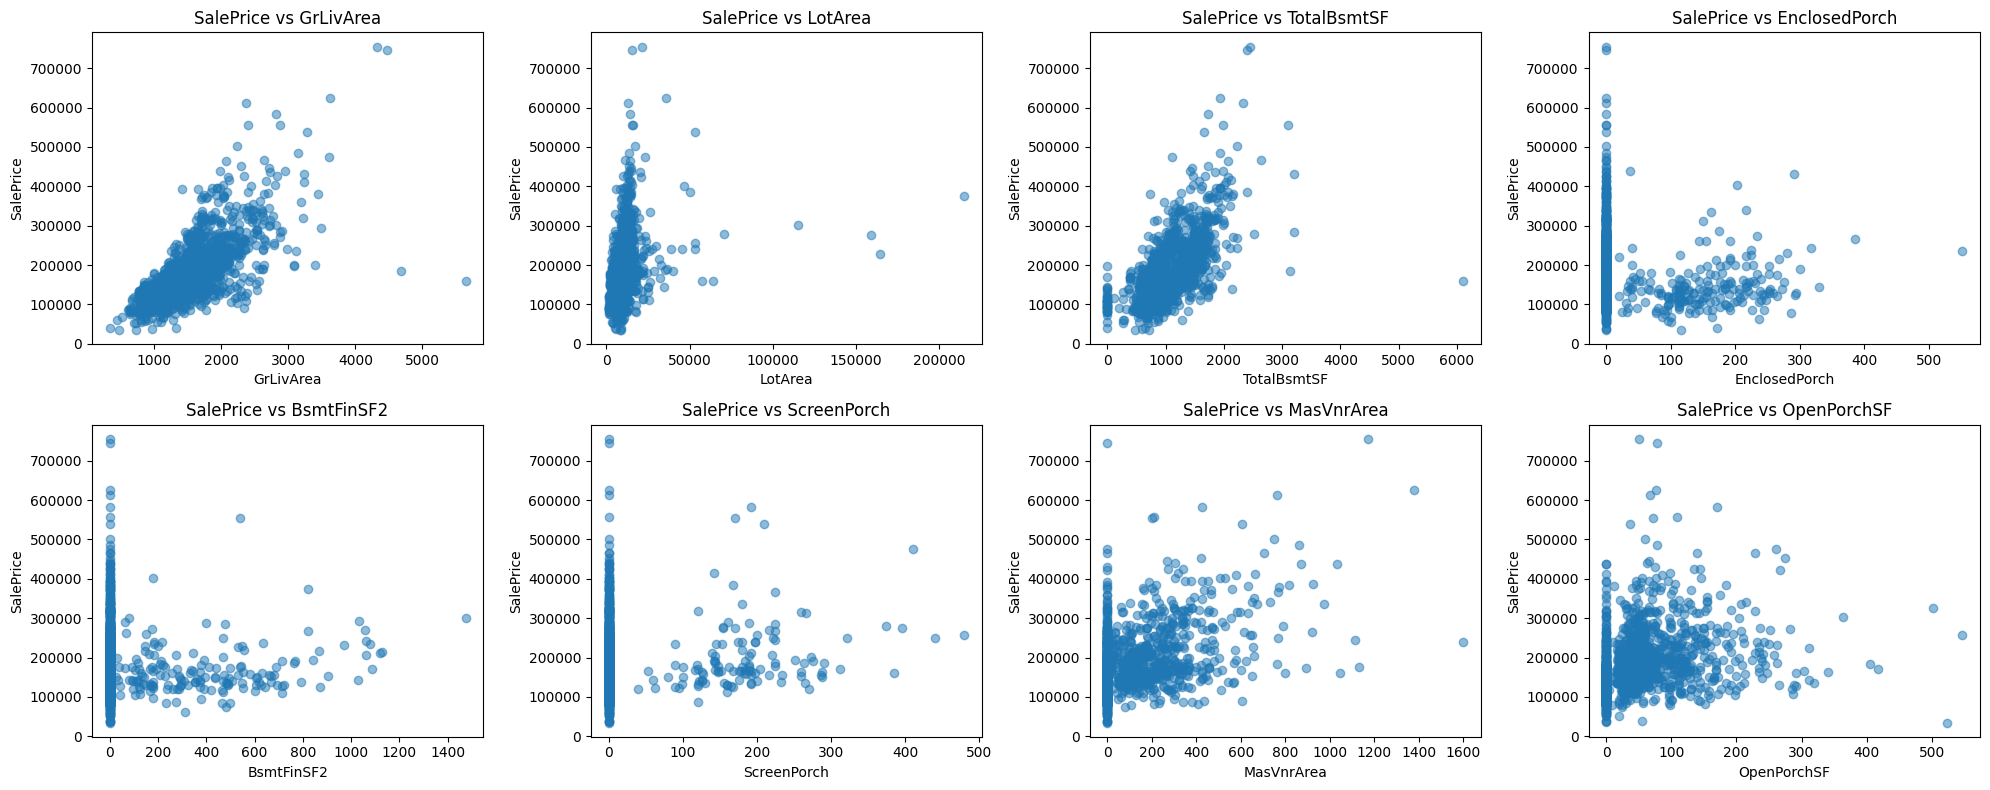

In [12]:
pairs = [
    ("GrLivArea", "SalePrice"),
    ("LotArea", "SalePrice"),
    ("TotalBsmtSF", "SalePrice"),
    ("EnclosedPorch", "SalePrice"),
    ("BsmtFinSF2", "SalePrice"),
    ("ScreenPorch", "SalePrice"),
    ("MasVnrArea", "SalePrice"),
    ("OpenPorchSF", "SalePrice")


]

plt.figure(figsize=(20, 8))

for i, (x_col, y_col) in enumerate(pairs, 1):
    plt.subplot(2, 4, i)
    plt.scatter(train[x_col], train[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")

plt.tight_layout()
plt.show()

For SalePrice vs Gr Liv Area, we will remove data with Gr Liv Ara > 3000 and SalePrice < 300000
For SalePrice vs Lot Area, we will remove data with Lot Area > 100000
For SalePrice vs Total Bsmt SF, we will remove data with Total Bsmt SF > 3000 and SalePrice < 300000
For SalePrice vs Enclosed Porch, we will remove data with Enclosed Porch > 400
For SalePrice vs BsmtFin SF 2, we will remove data with BsmtFin SF 2 > 1200
For SalePrice vs Screen Porch, we will remove data with Screen Porch > 400
For SalePrice vs Mas Vnr Area, we will remove data with Mas Vnr Area > 1400
For SalePrice vs Open Porch SF, we will remove data with Mas Vnr Area > 400

In [13]:
cond1 = (train['GrLivArea'] > 3000) & (train['SalePrice'] < 400000)
cond2 = train['LotArea'] > 100000
cond3 = (train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 300000)
cond4 = train['BsmtFinSF2'] > 1200
cond5 = train['ScreenPorch'] > 400
cond6 = train['MasVnrArea'] > 1400
cond7 = train['EnclosedPorch'] > 400
cond8 = train['OpenPorchSF'] > 400

outlier_condition = cond1 | cond2 | cond3 | cond4 | cond5 | cond6| cond7 | cond8
print(outlier_condition.sum())

23


In [14]:
#remove outlier
cleaned_train = train[~outlier_condition].copy()

# EXPLORATORY DATA ANALYSIS

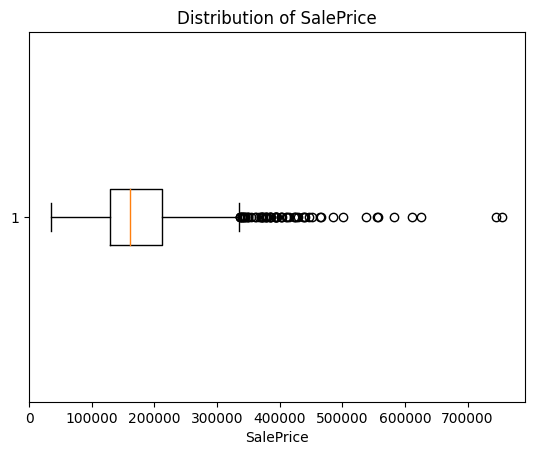

In [15]:
plt.boxplot(cleaned_train['SalePrice'], vert = False)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


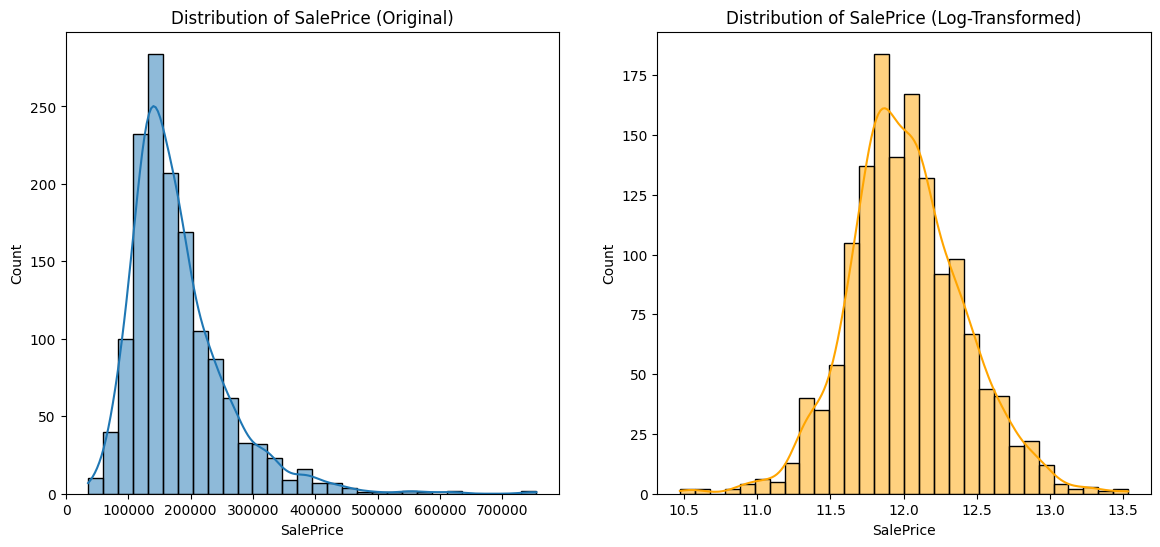

In [16]:
plt.figure(figsize=(14, 6))
# Original chart
plt.subplot(1, 2, 1)
sns.histplot(cleaned_train['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice (Original)")

# Log-transform chart
saleprice_log = np.log1p(cleaned_train['SalePrice'])
plt.subplot(1, 2, 2)
sns.histplot(saleprice_log, kde=True, bins=30, color='orange')
plt.title("Distribution of SalePrice (Log-Transformed)")

plt.show()

House prices are quite right-skewed, with luxury houses scattered at high price levels, which may impact linear regression. A log-transform could be applied before model training to make the distribution closer to normal

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

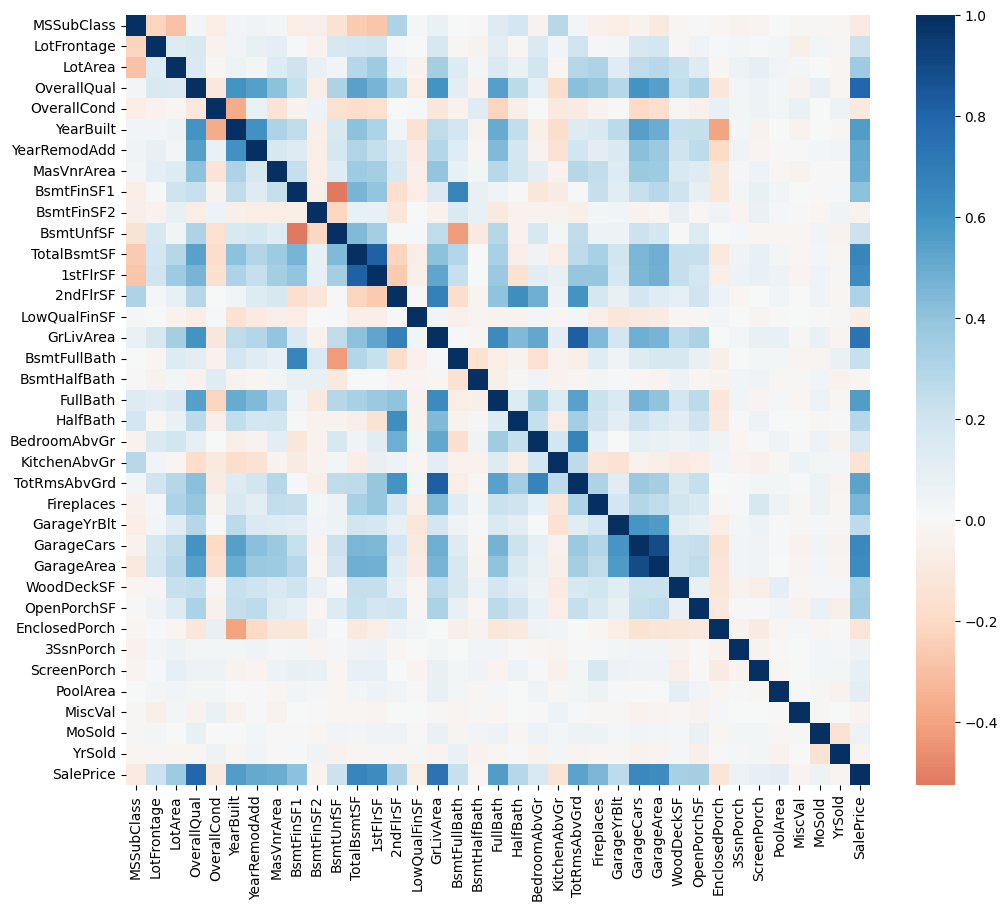

In [17]:
#Remove column ID which is not useful for analysis
cleaned_train = cleaned_train.drop('Id',axis=1)
#Heatmap to show correlation between numerical variables
plt.figure(figsize=(12, 10))
sns.heatmap(cleaned_train.select_dtypes(include=np.number).corr(), cmap="RdBu", center=0, annot=False)

We can see that SalePrice is highly positively correlated with Overall Qual, Total Bsmt SF, 1st Flr SF, Gr Liv Area, Garage Cars, Garage Area, Year Built, Year Remod/Add, Mas Vnr Area, Full Bath

We can better observe the relationship between SalePrice and each of these correlated variables using scatter plots

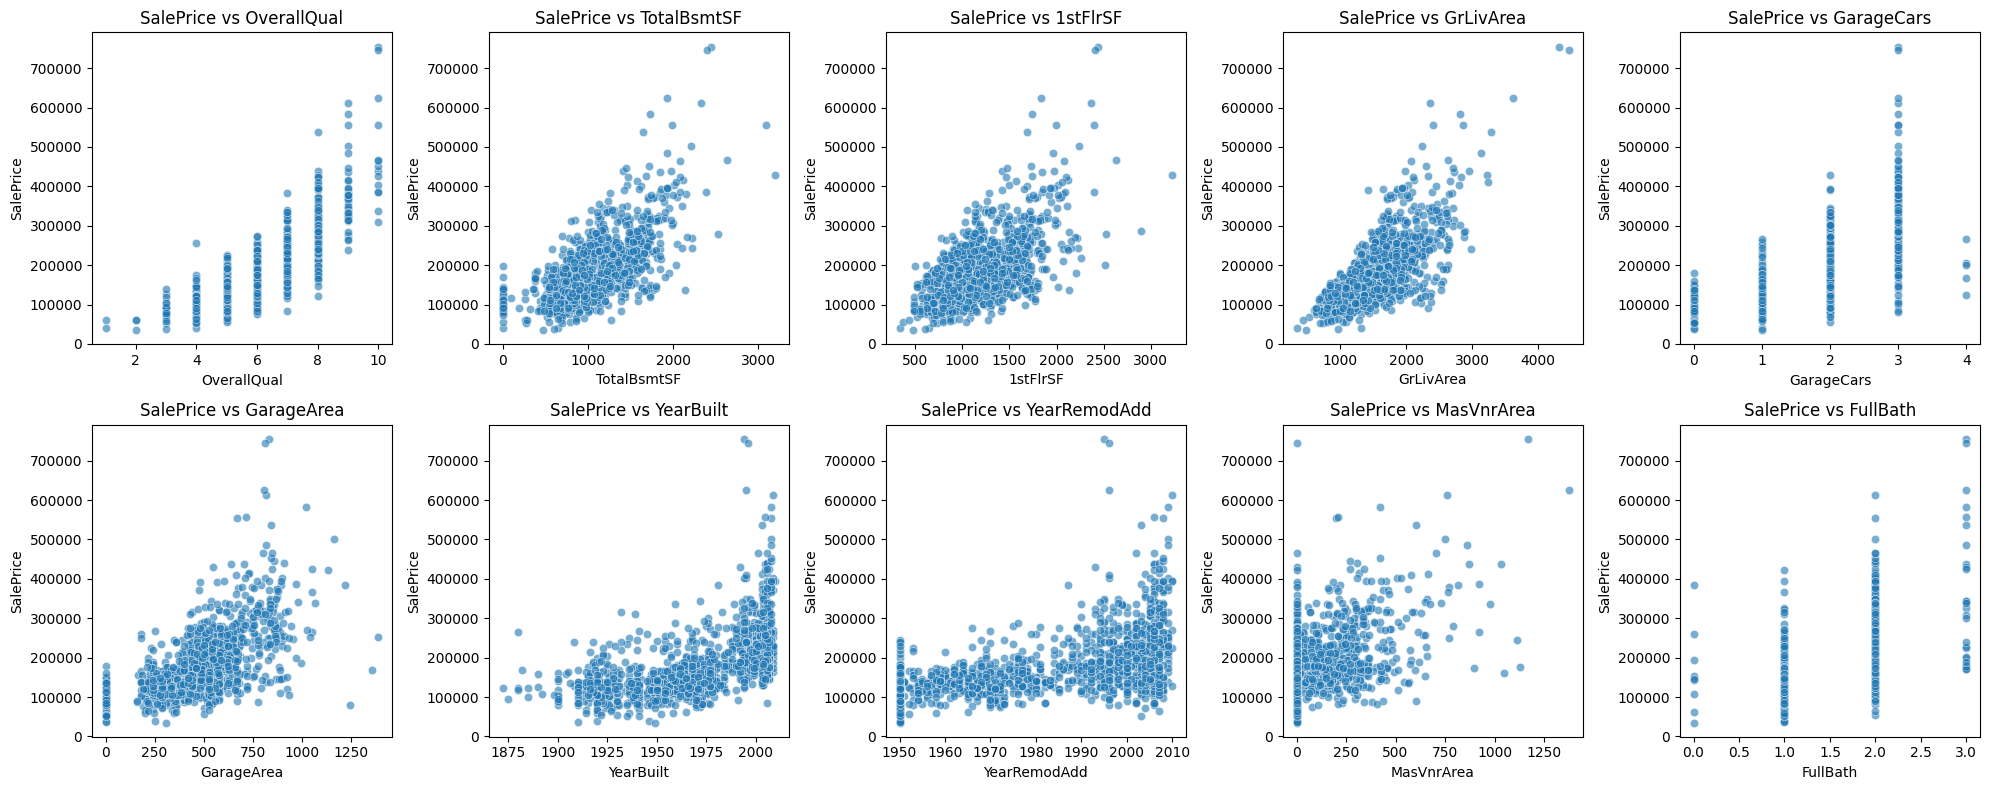

In [18]:
corr_variables =  ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'FullBath']
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(corr_variables):
    sns.scatterplot(
        data=cleaned_train, x=feature, y='SalePrice',
        alpha=0.6, ax=axes[i]
    )
    axes[i].set_title(f'SalePrice vs {feature}')

plt.tight_layout()
plt.show()

Overall Qual vs SalePrice Strong positive, almost linear relationship: higher quality → higher price. One of the most important variables.

Total Bsmt SF, 1st Flr SF, Gr Liv Area vs SalePrice Clear positive correlation with SalePrice. Some outliers with large area but low price. Gr Liv Area shows the strongest relationship.

Garage Cars & Garage Area vs SalePrice More car capacity → higher price. Garage Cars is more consistent (ordinal), Garage Area is more scattered.

Year Built & Year Remod/Add vs SalePrice Newer houses → higher price. Strong increase after 2000. Consider feature engineering (e.g., house age).

Mas Vnr Area vs SalePrice Slight positive trend but weak and scattered. Many zero values → less important variable.

Full Bath vs SalePrice Positive but weak correlation. Price increases with more bathrooms, but high dispersion at each level.

# FEATURE ENGINEERING

Dealing with multicollinearity

In [19]:
#We will check multicollinearity among features
corr_matrix = cleaned_train.select_dtypes(include=np.number).corr().abs()

# Take upper triangle to avoid duplicates (A-B and B-A)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Get |corr| >= 0.8
high_corr = [
    (col, row, corr_matrix.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if not pd.isnull(upper.loc[row, col]) and upper.loc[row, col] >= 0.8
]

for col, row, corr in high_corr:
    print(f"{row} - {col}: {corr:.2f}")

TotalBsmtSF - 1stFlrSF: 0.81
GrLivArea - TotRmsAbvGrd: 0.82
GarageCars - GarageArea: 0.89


We have 3 pairs:

Total Bsmt SF - 1st Flr SF --> remove 1st Flr SF,

Gr Liv Area - TotRms AbvGrd --> remove TotRms AbvGrd,

Garage Cars - Garage Area --> remove Garage Cars

In [20]:
cleaned_train = cleaned_train.drop(['1stFlrSF','TotRmsAbvGrd','GarageCars'], axis=1)

Dealing with ordinal variables

In [21]:
categorical_cols = cleaned_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {train[col].unique()}")

MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street: ['Pave' 'Grvl']
Alley: ['No Alley' 'Grvl' 'Pave']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1s

In [22]:
# transform ordinal variables
ordinal_mappings = {
    "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2},
    "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2,  "No Basement": 0},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Basement": 0},
    "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Fireplace": 0},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Garage": 0},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Garage": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "No Basement": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "No Basement": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "No Basement": 0},
    "Functional": {"Typ": 6, "Min1": 5, "Min2": 4, "Mod": 3, "Maj1": 2, "Maj2": 1, "Sev": 0},
    "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "No Fence": 0},
    "LandSlope": {"Gtl": 3, "Mod": 2, "Sev": 1},
    "PavedDrive": {"Y": 3, "P": 2, "N": 1}
}

for col, mapping in ordinal_mappings.items():
    if col in cleaned_train.columns:
        cleaned_train[col] = cleaned_train[col].map(mapping)



In [23]:
cleaned_train.isnull().values.sum()

0

In [24]:
#Recheck
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1437 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1437 non-null   int64  
 1   MSZoning       1437 non-null   object 
 2   LotFrontage    1437 non-null   float64
 3   LotArea        1437 non-null   int64  
 4   Street         1437 non-null   object 
 5   Alley          1437 non-null   object 
 6   LotShape       1437 non-null   object 
 7   LandContour    1437 non-null   object 
 8   Utilities      1437 non-null   object 
 9   LotConfig      1437 non-null   object 
 10  LandSlope      1437 non-null   int64  
 11  Neighborhood   1437 non-null   object 
 12  Condition1     1437 non-null   object 
 13  Condition2     1437 non-null   object 
 14  BldgType       1437 non-null   object 
 15  HouseStyle     1437 non-null   object 
 16  OverallQual    1437 non-null   int64  
 17  OverallCond    1437 non-null   int64  
 18  YearBuilt    

Define a function to apply the same cleaning process to the test set as used for the training set

In [25]:
def clean(df):
    df = df.copy()

    # Fill missing values
    df['PoolQC'] = df['PoolQC'].fillna("No Pool")
    df['MiscFeature'] = df['MiscFeature'].fillna('No Feature')
    df['Alley'] = df['Alley'].fillna('No Alley')
    df['Fence'] = df['Fence'].fillna('No Fence')
    df['MasVnrType'] = df['MasVnrType'].fillna('No Mas Vnr Type')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['FireplaceQu'] = df['FireplaceQu'].fillna('No Fireplace')
    df['LotFrontage'] = df['LotFrontage'].fillna(0)
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['KitchenQual'] = df['KitchenQual'].fillna('No Kitchen')

    

    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        if col in df.columns:
            df[col] = df[col].fillna("No Garage")

    for col in ['BsmtHalfBath','BsmtFullBath','TotalBsmtSF',
                'BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    for col in ["BsmtExposure", "BsmtFinType2", "BsmtFinType1",
                "BsmtQual", "BsmtCond"]:
        if col in df.columns:
            df[col] = df[col].fillna("No Basement")

    # Drop unnecessary columns
    drop_cols = ['Id','1stFlrSF','TotRmsAbvGrd','GarageCars']
    for col in drop_cols:
        if col in df.columns:
            df = df.drop(col, axis=1)


    # Ordinal mapping
    ordinal_mappings = {
        "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2},
        "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
        "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Basement": 0}, #Po for dataset test only
        "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Basement": 0},
        "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}, #Po is added for dataset test only
        "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Kitchen": 0},
        "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Fireplace": 0},
        "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Garage": 0},
        "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No Garage": 0},
        "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "No Basement": 0},
        "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3,
                           "LwQ": 2, "Unf": 1, "No Basement": 0},
        "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3,
                           "LwQ": 2, "Unf": 1, "No Basement": 0},
        "Functional": {"Typ": 6, "Min1": 5, "Min2": 4, "Mod": 3,
                       "Maj1": 2, "Maj2": 1, "Sev": 0, "Sal": -1,},  #Sal for dataset test only
        "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "No Fence": 0},
        "LandSlope": {"Gtl": 3, "Mod": 2, "Sev": 1},
        "PavedDrive": {"Y": 3, "P": 2, "N": 1}
    }

    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)


    return df

In [26]:
cleaned_test = clean(test)

In [27]:


from sklearn.impute import SimpleImputer

frequent_cols = ['Electrical', 'Utilities', 'MSZoning', 
                 'Exterior1st', 'Exterior2nd', 'Functional', 'SaleType']

cat_imputer = SimpleImputer(strategy="most_frequent")

cleaned_train[frequent_cols] = cat_imputer.fit_transform(cleaned_train[frequent_cols])
cleaned_test[frequent_cols]  = cat_imputer.transform(cleaned_test[frequent_cols])


In [28]:
cleaned_test.isnull().values.sum()

0

In [29]:
print(cleaned_train.shape)
print(cleaned_test.shape)

(1437, 77)
(1459, 76)


In [30]:
#Split dataset
y = cleaned_train['SalePrice']
X = cleaned_train.drop('SalePrice', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=SEED)
#y_log for ANN
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [31]:
#Create pipeline to Scale for numerical cols and One-Hot for categorical cols
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_cols = X_train.select_dtypes(exclude="object").columns
categorical_cols = X_train.select_dtypes(include="object").columns

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit train
X_train_trans = preprocessor.fit_transform(X_train)

# Transform valid/test
X_valid_trans = preprocessor.transform(X_valid)


In [32]:
print(X_train_trans.shape)
print(X_valid_trans.shape)

(1077, 226)
(360, 226)


# MODEL BUILDING

We aim to predict the SalePrice of a house from its features, and we choose ANN as the modeling technique

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [34]:
#add early stopping
early_stopping = callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor="val_loss"
)

In [35]:
input_shape = [X_train_trans.shape[1]]
input_shape


[226]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-14 10:02:43.564770: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Minimum Validation Loss: 0.0210
Minimum Validation RMSE: 0.1450


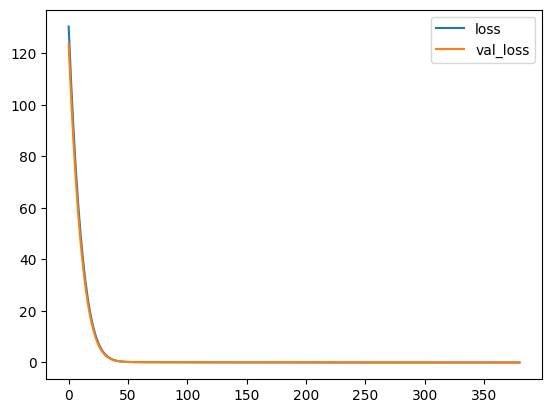

In [36]:
#build baseline model
baseline_model = keras.Sequential([
    layers.Dense(1, input_shape = input_shape)
])
baseline_model.compile(optimizer='adam', loss='mse', metrics = [RootMeanSquaredError()] )

baseline_history = baseline_model.fit(
    X_train_trans, y_train_log,
    validation_data = (X_valid_trans, y_valid_log),
    batch_size = 64,
    epochs = 500,
    callbacks=[early_stopping],
    verbose = 0,
)
baseline_history_df = pd.DataFrame(baseline_history.history)
baseline_history_df.loc[0:, ['loss','val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(baseline_history_df['val_loss'].min()))
print("Minimum Validation RMSE: {:0.4f}".format(baseline_history_df['val_root_mean_squared_error'].min()))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 1.3681
Minimum Validation RMSE: 1.1697


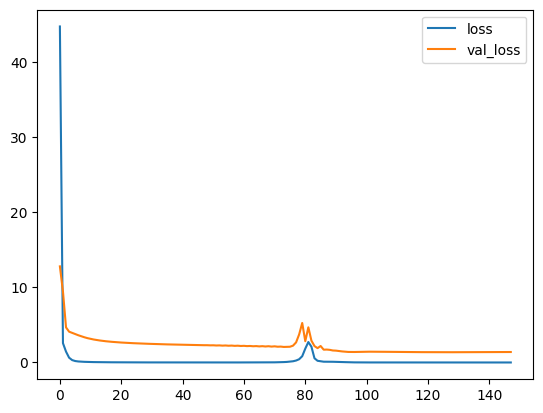

In [37]:
#build advanced ANN model
model_1 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_1.compile(
    optimizer='adam',
    loss='mse',
    metrics = [RootMeanSquaredError()]
)

#train model
history_1 = model_1.fit(
    X_train_trans, y_train_log,
    validation_data=(X_valid_trans, y_valid_log),
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping],
    verbose = 0
)
history_1_df = pd.DataFrame(history_1.history)
history_1_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_1_df['val_loss'].min()))
print("Minimum Validation RMSE: {:0.4f}".format(history_1_df['val_root_mean_squared_error'].min()))

The model shows overfitting (validation loss >> training loss). We will add Dropout and Regularization to mitigate it

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 1.3392
Minimum Validation RMSE: 1.1328


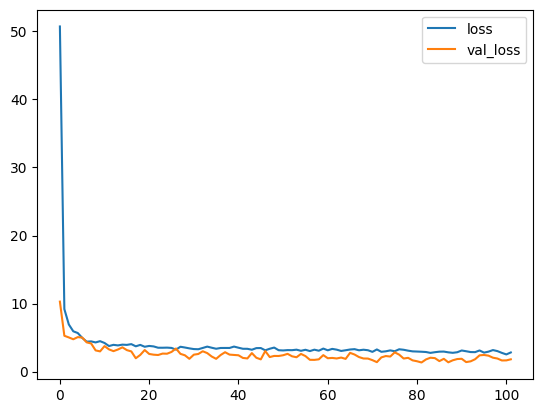

In [38]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

model_2 = Sequential([
    Dense(512, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.3),
    Dense(1)
])

model_2.compile(
    optimizer='adam',
    loss='mse',
    metrics = [RootMeanSquaredError()]
)

#train model
history_2 = model_2.fit(
    X_train_trans, y_train_log,
    validation_data=(X_valid_trans, y_valid_log),
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping],
    verbose = 0
)
history_2_df = pd.DataFrame(history_2.history)
history_2_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_2_df['val_loss'].min()))
print("Minimum Validation RMSE: {:0.4f}".format(history_2_df['val_root_mean_squared_error'].min()))

Baseline model yields the best result, so we will keep the ANN baseline model as standard

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_log = baseline_model.predict(X_valid_trans).ravel()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid_log)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R2: {r2:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation MSE: 572399008.68
Validation RMSE: 23924.86
Validation MAE: 15571.29
Validation R2: 0.895


Feature importances can essentially be derived from the weights of the first layer.

In [40]:
weights, bias = baseline_model.layers[0].get_weights()
importances = np.abs(weights[:, 0])
feature_names = preprocessor.get_feature_names_out()
s = pd.Series(np.abs(weights[:, 0]), index=feature_names)
grouped = s.groupby(lambda x: x.split('__')[1].split('_')[0]).sum().sort_values(ascending=False)
print(grouped.head(10))


Neighborhood    8.190567
Exterior2nd     5.905228
Exterior1st     5.584579
Condition1      3.436980
SaleType        3.034500
RoofStyle       2.851017
HouseStyle      2.840419
Condition2      2.491253
Foundation      2.198988
LandContour     2.072882
dtype: float32


We’ll try RandomForestRegressor for comparison.

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
#Create a a new preprocessing data for X with One-Hot only (no need to do Feature Scale in RandomForestRegressor)
numeric_cols = X_train.select_dtypes(exclude="object").columns
categorical_cols = X_train.select_dtypes(include="object").columns

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

# Fit train
X_train_trans_rf = preprocessor_rf.fit_transform(X_train)

# Transform valid/test
X_valid_trans_rf = preprocessor_rf.transform(X_valid)
# X_test_trans_rf  = preprocessor.transform(X_test)


In [43]:
print(X_train_trans_rf.shape)
print(X_valid_trans_rf.shape)


(1077, 226)
(360, 226)


In [44]:
rfr = RandomForestRegressor( n_estimators=500, max_depth=20, random_state=8, n_jobs=-1 )
rfr.fit(X_train_trans_rf, y_train_log)
y_valid_log_pred_rf = rfr.predict(X_valid_trans_rf)
y_valid_pred_rf = np.expm1(y_valid_log_pred_rf)

mae_rf = mean_absolute_error(y_valid, y_valid_pred_rf)
mse_rf = mean_squared_error(y_valid, y_valid_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_valid, y_valid_pred_rf)

print(f"Validation MSE: {mse_rf:.2f}")
print(f"Validation MAE: {mae_rf:.4f}")
print(f"Validation RMSE: {rmse_rf:.4f}")
print(f"Validation R²: {r2_rf:.4f}")

Validation MSE: 652135743.63
Validation MAE: 16583.5056
Validation RMSE: 25536.9486
Validation R²: 0.8800


Try using GridSearchCV to find better hyperparameters

In [45]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[10,15,20,None],
    'max_features':['sqrt','log2',0.3,0.5],
    'min_samples_leaf':[1,2,5],
}
rfr = RandomForestRegressor(n_estimators=500, random_state=8, n_jobs=-1)
grid = GridSearchCV(rfr, params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train_trans_rf, y_train_log)
print(grid.best_params_, -grid.best_score_)

y_valid_log_pred_rf = grid.predict(X_valid_trans_rf)
y_valid_pred_rf = np.expm1(y_valid_log_pred_rf)

mae_rf = mean_absolute_error(y_valid, y_valid_pred_rf)
mse_rf = mean_squared_error(y_valid, y_valid_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_valid, y_valid_pred_rf)

print(f"Validation MSE: {mse_rf:.2f}")
print(f"Validation MAE: {mae_rf:.4f}")
print(f"Validation RMSE: {rmse_rf:.4f}")
print(f"Validation R²: {r2_rf:.4f}")


{'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1} 0.12966945065658217
Validation MSE: 605827099.50
Validation MAE: 15715.4603
Validation RMSE: 24613.5552
Validation R²: 0.8885


I tuned RandomForest with GridSearchCV, got some improvements, but ANN still performs better — so ANN is my final choice

# Final model

Train final model on the whole train dataset

In [46]:
X_trans = preprocessor.fit_transform(X)
print(X_trans.shape)
y_log = np.log1p(y)


(1437, 235)


In [47]:
input_shape_1 = X_trans.shape[1]
ann_model = keras.Sequential([
    layers.Dense(1, input_shape=(input_shape_1,))
])
ann_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
ann_model.fit(X_trans, y_log, epochs=200, batch_size=64, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
#scale + Onehot test set
cleaned_test_trans = preprocessor.transform(cleaned_test)
#predict test set
y_test_pred_ann = np.expm1(ann_model.predict(cleaned_test_trans).ravel())

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_ann
})


# Evaluation & Conclusion

After submitting the predictions to Kaggle, my model achieved a score of 0.15286 on the public leaderboard, placing me at position 2565 out of 4006 participants at the time of submission.

In this experiment, the ANN outperformed the Random Forest even though both used the same preprocessed features and log-transformed target. A single dense layer is essentially a linear combination with a nonlinearity; with scaled inputs and log(y), it behaves like OLS/ElasticNet regression on log(y), which is very effective for tabular data. The Random Forest, while using the same information, does not capture this smooth linear relationship as efficiently, resulting in slightly lower accuracy.